# ASL Translator
## This is the master preprocessing pipeline

### Plan for classification

    1. Train original images, output classification accuracy with original images
    2. Train preprocessed images, output classification accuracy with preprocessed images
    3. Compare accuracy between original images model and preprocessed images model

### Proposed pipeline

- preprocess the images (this stuff)
    - pick 2 or 3 different operation results
- feed into Kira's mask algorithm
    - removing background and keeping hand

- normal images for training -> preprocessed images for testing

In [8]:
import os
import glob
import imageio
import scipy.io
from scipy import ndimage
from skimage import feature
from skimage import exposure
from skimage import morphology
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import gaussian
from skimage.filters.rank import median
from skimage.morphology import disk, ball
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>


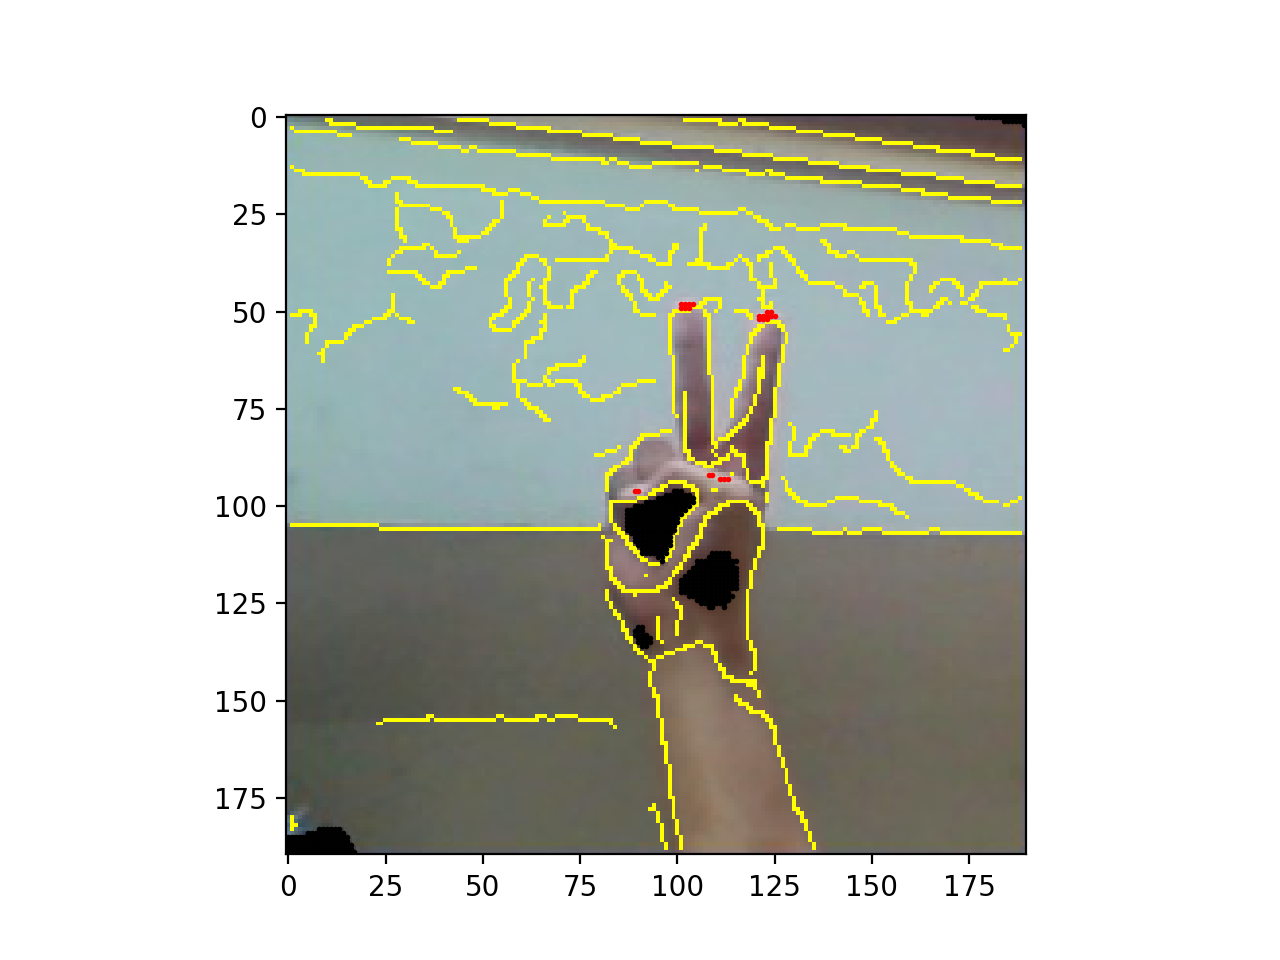

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [12]:
framesdir = "../image-classification-tensorflow-master/dataset/V/"
fnames = glob.glob(framesdir + "*.jpg")
fnames = [os.path.basename(name) for name in fnames]

random_indeces = np.random.choice(len(fnames), 1, replace=False)
chosen_fnames = np.take(fnames, random_indeces)
    
# original image
original_image = imageio.imread(framesdir + chosen_fnames[0])

# crop original image 5px from each side to remove border
height, width, channels = original_image.shape
original_image = original_image[5:width-5,5:height-5,:]

# grayscale image
gray_img = rgb2gray(original_image)

# enhance contrast of the gray image
high_contrast = exposure.equalize_hist(gray_img) * 255

# reduce noise from enhanced image
noiseless_img = median(high_contrast / 255, disk(3))

# perform canny edge detector on reduced noise image
edges_img = feature.canny(noiseless_img, sigma=1)

######## COMBINED IMAGES WITH EDGES_IMG ########

# overlay edges on original image
inv_edges = np.where(edges_img == 1, 0, 1)
combined_og = original_image * np.stack((inv_edges,inv_edges,inv_edges), axis=-1)   
for yy in range(combined_og.shape[0]):
    for xx in range(combined_og.shape[1]):
        if np.array_equal(combined_og[yy,xx], np.zeros(3)):
            combined_og[yy,xx] = np.array([255,255,0])

# now, the output of part 1 of preprocessing (combined_og) will be available in PART1OUTPUT
PART1OUTPUT = combined_og
# show this output if you like
plt.imshow(PART1OUTPUT)

# Use threshold in gray image to find light and dark spots (separate thresholds may be used)
threshold = 0.25
light_spots = np.array((gray_img > 1- threshold).nonzero()).T
plt.plot(light_spots[:, 1], light_spots[:, 0], 'o', color='red', markersize=1)
dark_spots = np.array((gray_img < threshold).nonzero()).T
plt.plot(dark_spots[:, 1], dark_spots[:, 0], 'o', color='black', markersize=1)

bool_mask = np.zeros(gray_img.shape, dtype=np.bool)
bool_mask[tuple(light_spots.T)] = True
bool_mask[tuple(dark_spots.T)] = True
seed_mask, num_seeds = ndimage.label(bool_mask)

# Watershed mask to be used in the future to find the background and foreground
ws = morphology.watershed(noiseless_img, seed_mask)
# plt.imshow(ws)
plt.show()